In [1]:
from skimage.transform import PolynomialTransform as Poly
import numpy as np
import pandas as pd
from skimage import transform
import skimage.io as io
import matplotlib.pyplot as plt
from PIL import Image
from numpy.testing import assert_almost_equal
from random import random, uniform
from sklearn.metrics import mean_squared_error
from math import dist
from skimage.filters import gaussian
plt.rcParams['figure.dpi'] = 300

In [42]:
def residual_cal(src, dst):
    mse = mean_squared_error(src, dst)
    return mse


def save_np_img(npimg, path):
    img = Image.fromarray(npimg)
    img = img.convert("L")
    img.save(path, dpi=(300.0, 300.0))


def ploting_res(canvas_size, res, pts_radius, save_path):
    x_range, y_range = canvas_size
    pk_img = np.zeros(canvas_size)
    for ele in res:
        y = int(ele[0])
        x = int(ele[1])
        for j in range(0, pts_radius):
            for k in range(0, pts_radius):
                pk_img[min(max(0, x - j), x_range - 1),
                    min(max(0, y - k), y_range - 1)] = 1024 * 2
                pk_img[min(x_range - 1, x + j),
                    min(max(0, y - k), y_range - 1)] = 1024 * 2
                pk_img[min(x_range - 1, x + j),
                    min(y_range - 1, y + k)] = 1024 * 2
                pk_img[min(max(0, x - j), x_range - 1),
                    min(y_range - 1, y + k)] = 1024 * 2
    blurred_img = gaussian(pk_img, sigma=3, multichannel=False)
    save_np_img(blurred_img, save_path)


def fake_data_test(marker_num, pts_num, noise_rate, displacement=False):
    def poly_3_trans(pts, x_params, y_parms, displacement=False):
            x, y = pts
            poly_terms = np.array([1, x, y, x * x, x * y, y * y, x * x * x, x * x * y, x * y * y, y * y * y])
            # print(poly_terms)
            return np.array((np.dot(poly_terms, x_params.reshape(10, 1)) + int(displacement) * np.random.normal(loc=3, scale=3, size=1)[0], 
                             np.dot(poly_terms, y_parms.reshape(10, 1) + int(displacement) * np.random.normal(loc=3, scale=3, size=1)[0]))).reshape(1, 2)[0]

    def generate_data(marker_num, pts_num, noise_rate):
        rng = np.random.default_rng(seed=428)
        beads_movie = rng.random((marker_num, 2))
        beads_movie[:, 0] = beads_movie[:, 0] * 256
        beads_movie[:, 1] = beads_movie[:, 1] * 512

        pts_movie = rng.random((pts_num, 2))
        pts_movie[:, 0] = pts_movie[:, 0] * 256
        pts_movie[:, 1] = pts_movie[:, 1] * 512

        # poly_trans_x_params = np.random.normal(loc=2, scale=1, size=10)
        # poly_trans_y_params = np.random.normal(loc=2, scale=1, size=10)
        # poly_trans_x_params = np.ones((10, 1))
        poly_trans_x_params = np.array([-181.42149878341644, 7.512515275589122, 6.5142480464264265, 0.0057307135507819644, -0.050887234358891614, -0.012077111940913236, -2.7315150951088216e-05, 9.199782464861516e-05, 6.125989003219573e-05, 7.666340508330289e-07])
        poly_trans_y_params = np.array([-698.9907615136117, 6.186382401506084, 22.584236882212387, -0.0011193284807307165, -0.14345083473014503, -0.021153463917421282, -3.564021898664521e-05, 0.0002703737578728173, 0.000156067089278071, -1.9121326943110133e-05])

        beads_fastq = np.zeros((marker_num, 2))
        for i in range(0, len(beads_movie)):
            beads_fastq[i] = poly_3_trans(beads_movie[i], poly_trans_x_params, poly_trans_y_params, displacement)
        pts_fastq = np.zeros((pts_num, 2))
        for i in range(0, pts_num):
            pts_fastq[i] = poly_3_trans(pts_movie[i], poly_trans_x_params, poly_trans_y_params, displacement)
        if noise_rate > 0:
            noise_fastq = rng.random((int(pts_num * noise_rate), 2))
            noise_fastq[:, 0] = noise_fastq[:, 0] * 256
            noise_fastq[:, 1] = noise_fastq[:, 1] * 512
            for i in range(0, (int(pts_num * noise_rate))):
                noise_fastq[i] = poly_3_trans(noise_fastq[i], poly_trans_x_params, poly_trans_y_params, displacement)
            pts_fastq = np.concatenate((pts_fastq, noise_fastq))
        return beads_movie, beads_fastq, pts_movie, pts_fastq
        
    beads_movie, beads_fastq, pts_movie, pts_fastq = generate_data(marker_num, pts_num, noise_rate)
    # ploting_res((256, 512), beads_movie, 1, '/Users/qinhanhou/Desktop/DeindlLab/0729Poly/PolyTest/beads_movie.png')
    # ploting_res((256, 512), pts_movie, 1, '/Users/qinhanhou/Desktop/DeindlLab/0729Poly/PolyTest/pts_movie.png')
    # ploting_res((int(2.5e3), int(5e3)), beads_fastq, 3, '/Users/qinhanhou/Desktop/DeindlLab/0729Poly/PolyTest/beads_fastq.png')
    # ploting_res((int(2.5e3), int(5e3)), pts_fastq, 3, '/Users/qinhanhou/Desktop/DeindlLab/0729Poly/PolyTest/pts_fastq.png')
    # print(beads_movie)
    # print(beads_fastq)
    tform = transform.estimate_transform('polynomial', src=beads_movie, dst=beads_fastq, order=3)
    res = tform(np.array(pts_movie))
    print(residual_cal(pts_fastq, res))
    


In [270]:
fake_data_test(10, 40, 0)

6.201997424272543e-10


## Wrap image to see the image-level alignment result.

[[1.64452575e+02 5.96553476e+00 6.06946512e-02]
 [1.35890146e+02 1.74959298e-02 5.98072391e+00]]
[[ 61.038  26.231]
 [ 71.885 136.885]
 [267.833 164.611]
 [159.195 213.771]
 [ 33.    226.5  ]]
[[ 61.03778449  26.23144765]
 [ 71.88486635 136.88500169]
 [267.83339961 164.61116566]
 [159.19513491 213.77080564]
 [ 32.99980615 226.49957249]]
[[ 529.858  293.641]
 [ 602.434  956.69 ]
 [1771.721 1123.962]
 [1127.841 1419.024]
 [ 374.257 1489.663]]
[[ 530.16896761  293.83843177]
 [ 601.59322911  955.8192338 ]
 [1772.21065468 1125.06907742]
 [1127.11063819 1417.18074208]
 [ 375.06256103 1491.10147789]]
0.971536707638339
7.281559472494453e-08


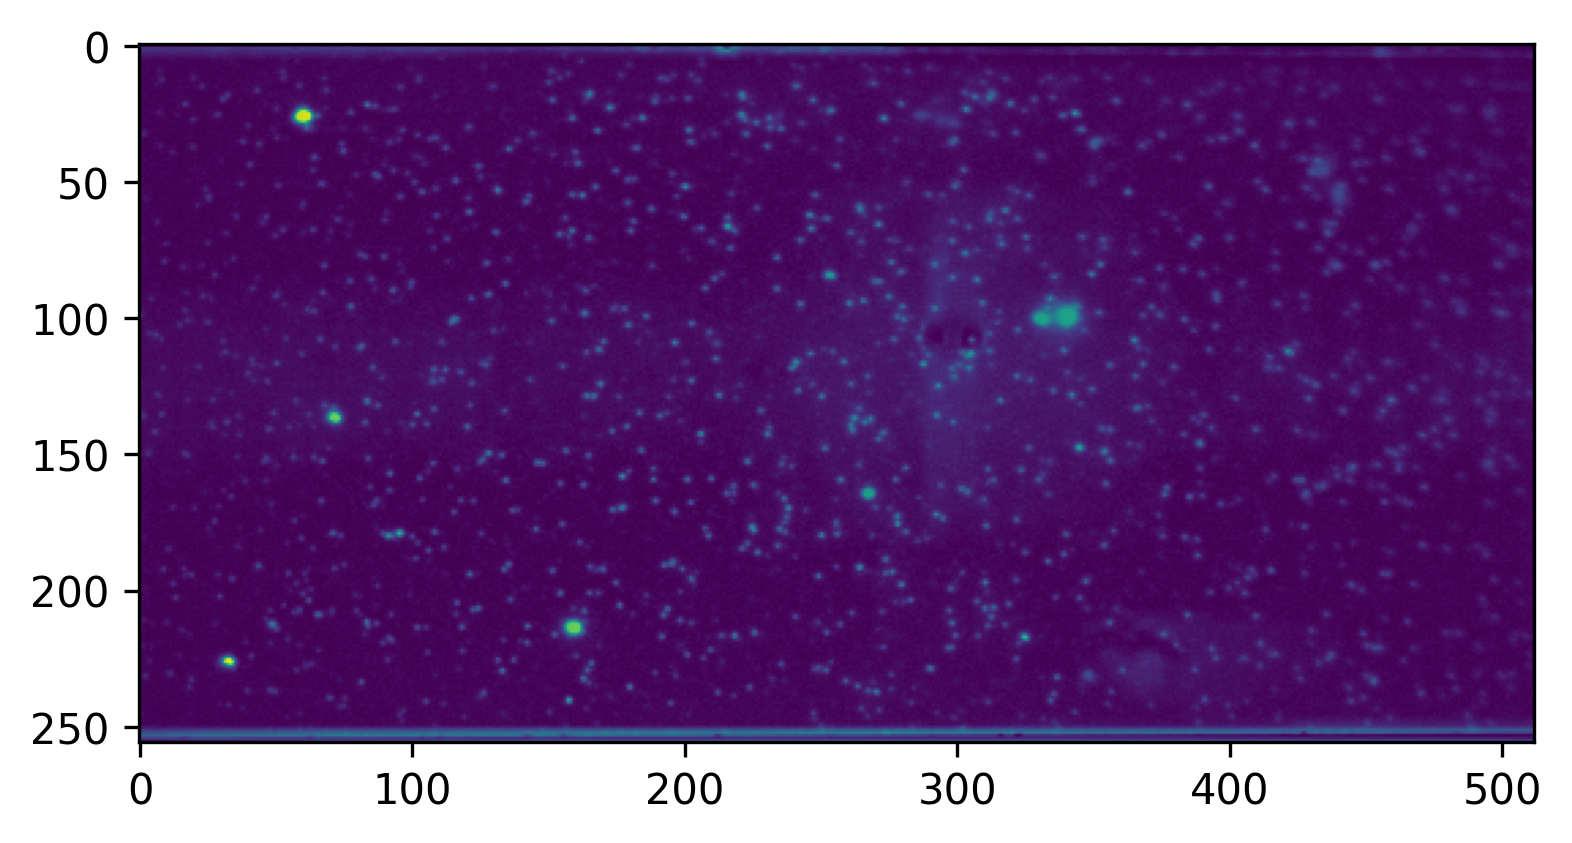

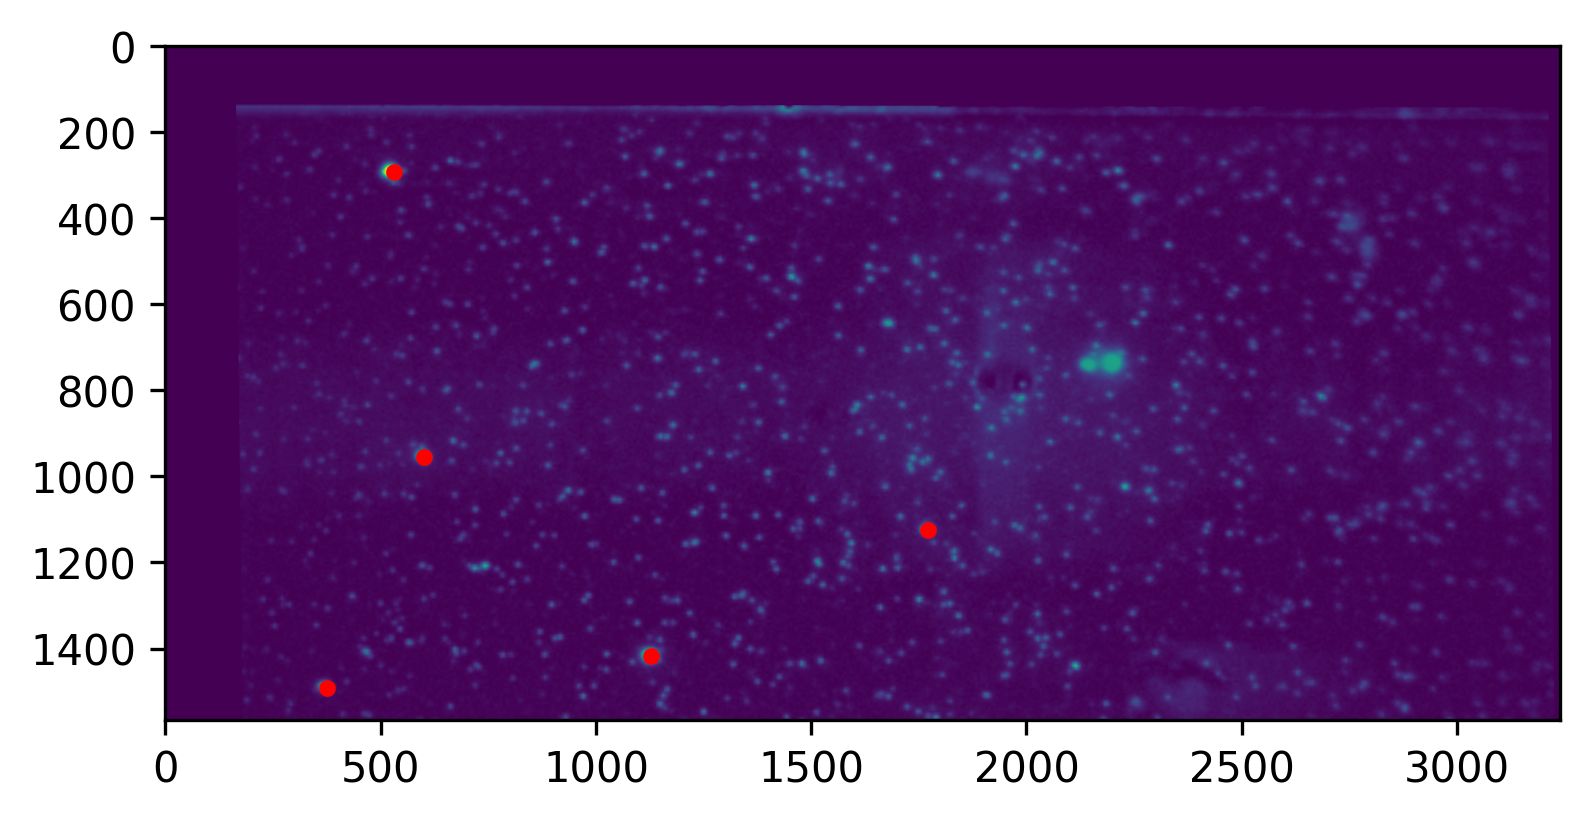

In [43]:
from re import T


res_tb = pd.read_csv('/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/Results.csv')
sample_num = int(len(res_tb) / 2)
# print(np.array(res_tb['Y'][0:sample_num]))
# print(np.column_stack((np.array(res_tb['Y'][0:sample_num]), np.array(res_tb['X'][0:sample_num]))))
src = np.column_stack((np.array(res_tb['XM'][0:sample_num]), np.array(res_tb['YM'][0:sample_num])))
dst = np.column_stack((np.array(res_tb['XM'][sample_num:]), np.array(res_tb['YM'][sample_num:])))
# print(src)
# print(tform(src))
# print(dst)
# print(len(src))
# print(len(dst))

class PolyTrans(transform.PolynomialTransform):
    def estimate(*data):
        return transform.PolynomialTransform.estimate(*data, order=2)

tform_src_to_dst = transform.estimate_transform('polynomial', src=src, dst=dst, order=1)
print(tform_src_to_dst.params)
tform_dst_to_src = transform.estimate_transform('polynomial', src=dst, dst=src, order=1)

res = tform_src_to_dst(src)
back_src = tform_dst_to_src(res)

print(src)
print(back_src)

print(dst)
print(res)

print(residual_cal(res, dst))
print(residual_cal(src, back_src))

img = io.imread('/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/movie_average_projection_246.tif')
plt.figure()
plt.imshow(img)
x_range = 1566
y_range = 3240
# x_range = 256  
# y_range = 512
# print(tform.params)
warped = transform.warp(img, tform_dst_to_src, output_shape=(x_range, y_range))
# print(img)
# print(img.shape)
# print(np.swapaxes(img, 0, 1))
# print(np.swapaxes(img, 0, 1).shape)
image = Image.fromarray(warped)
image.save('/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/movie_min_projection_246_w.tif')
plt.figure()
plt.plot(res[:, 0], res[:, 1], '.r')
plt.imshow(warped)

ploting_res((x_range, y_range), res, 3, '/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/transformed_beads.tif')
ploting_res((x_range, y_range), dst, 3, '/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/dst_beads.tif')


In [274]:
from tkinter import Y
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

from tkinter import Y
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, n_feature, n_output):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, 8)
        # self.hidden2 = torch.nn.Linear(8, 8)
        self.predict = torch.nn.Linear(8, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        # x = F.relu(self.hidden2(x))
        x = self.predict(x)
        return x

model = NeuralNetwork(n_feature=2, n_output=2).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

res_tb = pd.read_csv('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0808/Results.csv')
sample_num = int(len(res_tb) / 2)
# print(np.array(res_tb['Y'][0:sample_num]))
# print(np.column_stack((np.array(res_tb['Y'][0:sample_num]), np.array(res_tb['X'][0:sample_num]))))
src = np.column_stack((np.array(res_tb['Y'][0:sample_num]), np.array(res_tb['X'][0:sample_num])))
src_v = torch.from_numpy(src.astype(np.float32))
dst = np.column_stack((np.array(res_tb['Y'][sample_num:]), np.array(res_tb['X'][sample_num:])))
dst_v = torch.from_numpy(dst.astype(np.float32))


for t in range(10000):
    prediction = model(src_v)
    loss = loss_fn(prediction, dst_v)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(model(src_v))
print(dst_v)

Using cpu device
tensor([[ 294.9398,  529.3074],
        [ 955.2356,  598.4745],
        [1489.4929,  369.5218],
        [1420.0492, 1127.7278],
        [ 740.4353, 2201.2944],
        [1412.2332,  464.5072],
        [1280.4548,  436.5154],
        [1210.0364,  738.2871],
        [1530.9141, 2267.9114],
        [1125.6588, 1777.7992]], grad_fn=<AddmmBackward0>)
tensor([[ 294.0000,  530.0000],
        [ 955.5000,  601.5000],
        [1489.5000,  371.5000],
        [1421.5000, 1133.5000],
        [ 739.5000, 2201.5000],
        [1407.5000,  459.5000],
        [1281.5000,  431.5000],
        [1213.5000,  741.5000],
        [1529.5000, 2269.5000],
        [1127.5000, 1771.5000]])


In [275]:
peaks_tb = pd.read_csv('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0808/res_maximum.csv')
sample_num_peaks = int(len(peaks_tb))
# print(np.array(res_tb['Y'][0:sample_num]))
# print(np.column_stack((np.array(res_tb['Y'][0:sample_num]), np.array(res_tb['X'][0:sample_num]))))
peak_locations = np.column_stack((np.array(peaks_tb['Y'][0:sample_num_peaks]), np.array(peaks_tb['X'][0:sample_num_peaks])))

# peak_location_v = torch.from_numpy(np.array(peak_locations).astype(np.float32))
# model.eval()
# res = model(peak_location_v).cpu().detach().numpy()

tform_1 = transform.estimate_transform('polynomial', src=src, dst=dst, order=1)
poly_res_1 = tform_1(np.array(peak_locations))

tform_2 = transform.estimate_transform('polynomial', src=src, dst=dst, order=2)
poly_res_2 = tform_2(np.array(peak_locations))


tform_3 = transform.estimate_transform('polynomial', src=src, dst=dst, order=3)
poly_res_3 = tform_3(np.array(peak_locations))

save_path = '/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0810/'
canvas_size = (1566, 3240)
# ploting_res(canvas_size, res, 3, save_path + 'transformed_res_NN_test.png')
ploting_res(canvas_size, poly_res_3, 3, save_path + 'transformed_res_poly3.png')